In [1]:
import pandas as pd
import numpy as np
import pickle
import torch
import os
import torch
import matplotlib.pyplot as plt
import networkx as nx
import scipy.signal

In [2]:
csv_file = 'nmr_smile_solvent_web_sat_combined2.csv'
df = pd.read_csv(csv_file)
# print(len(df)) #28848
# csv_file = 'nmr_smile_solvent_web_sat_combined2_distilled.csv'
# df = pd.read_csv(csv_file)
# print(len(df)) #28848

fpt_path = '/scratch0/yunruili/2dnmr_30k/fingerprint/'
nmr_path = '/scratch0/yunruili/2dnmr_30k/nmr_1dcsv_30k/'

file_list = df['File_name'].to_list()

## load fingerprint pkl

In [3]:
# load pkl
idx = 100
print(file_list[idx])
filename = file_list[idx].split('.')[0] + '.pkl'
file = os.path.join(fpt_path, filename)
# Load the data from the file
with open(file, 'rb') as f:
    fpt_data = pickle.load(f)
f.close()

# Print the loaded data (or perform other operations as needed)
print(fpt_data)
print(fpt_data.shape)

01498.csv
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([2048])


In [4]:
torch.sum(fpt_data)

tensor(28.)

## load NMR

In [5]:
# load NMR
idx = 10
filename = file_list[idx].split('.')[0] + '.csv'
file = os.path.join(nmr_path, filename)
nmr_data = pd.read_csv(file)['13C']
# nmr_data = torch.tensor(nmr_data)
print(nmr_data)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
996     0.0
997     0.0
998     0.0
999     0.0
1000    0.0
Name: 13C, Length: 1001, dtype: float64


#### visualize NMR

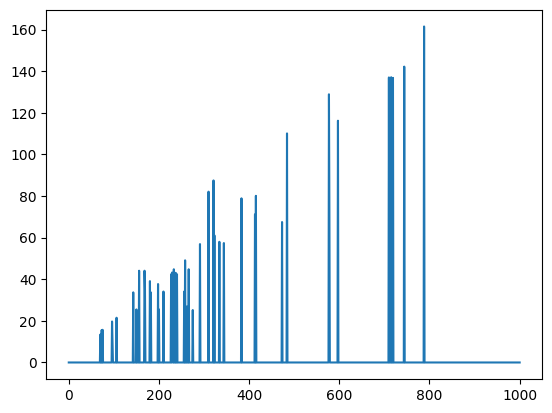

In [6]:
plt.plot(np.arange(nmr_data.shape[0]), nmr_data)

#### gaussian blur

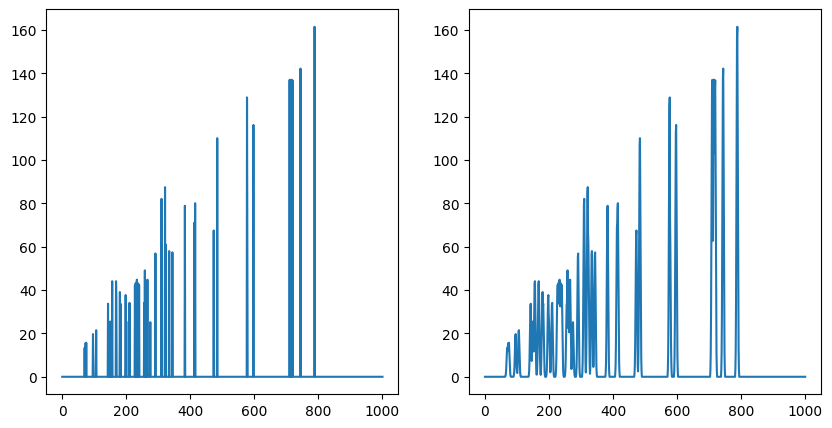

In [7]:
# nmr_data = nmr_data/200
# Parameters for Gaussian noise
std_dev = 2  # Standard deviation of the Gaussian noise, adjust as needed

# Identify peak locations
peak_locations = np.where(nmr_data > 0)[0]  # Adjust the condition as needed

# Create a noise vector initialized to zero
nmr_blur = np.zeros_like(nmr_data)

# Apply Gaussian smoothing at each peak
for peak in peak_locations:
    # Generate a Gaussian distribution centered at the peak
    gaussian = scipy.signal.gaussian(2 * std_dev * 3, std_dev)
    # gaussian = gaussian / gaussian.sum()  # Normalize the Gaussian
    gaussian *= nmr_data[peak]
    # Determine the range for applying the Gaussian
    start = max(peak - std_dev * 3, 0)
    end = min(peak + std_dev * 3, nmr_data.shape[0])

    # Apply Gaussian smoothing to the range
    for i in range(start, end):
        if nmr_blur[i] < gaussian[i - start]:
            nmr_blur[i] = gaussian[i - start]
    # nmr_blur[start:end] += smoothed_range * gaussian[std_dev * 3 - (peak - start): std_dev * 3 + (end - peak)]

# Make sure peak values remain unchanged
nmr_blur[peak_locations] = nmr_data[peak_locations]

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(np.arange(nmr_data.shape[0]), nmr_data)
plt.subplot(122)
plt.plot(np.arange(nmr_data.shape[0]), nmr_blur)

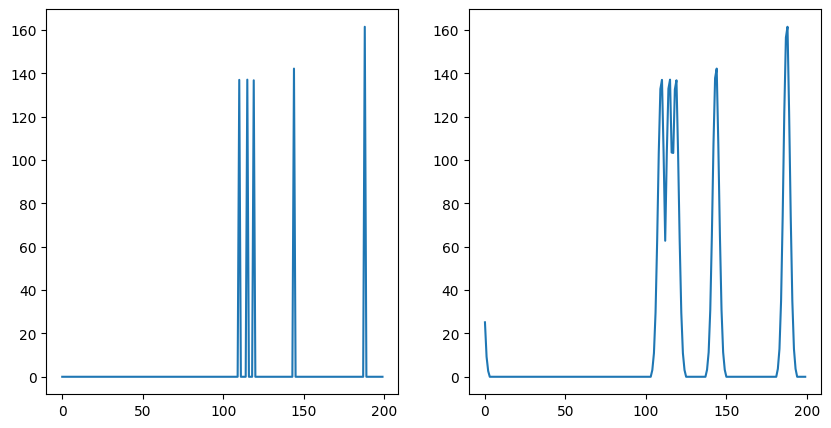

In [8]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(np.arange(200), nmr_data[600:800])
plt.subplot(122)
plt.plot(np.arange(200), nmr_blur[600:800])

## load graph

In [15]:
idx = 100
filename = file_list[idx].split('.')[0] + '.pickle'
graph = pickle.load(open(os.path.join(graph_path, filename), 'rb'))


#### visualize graph


In [18]:
df.iloc[100]

Unnamed: 0                      100
File_name                 01498.csv
SMILES        CNCCC1=CNC2=CC=CC=C21
Solvent                     DMSO-d6
Name: 100, dtype: object

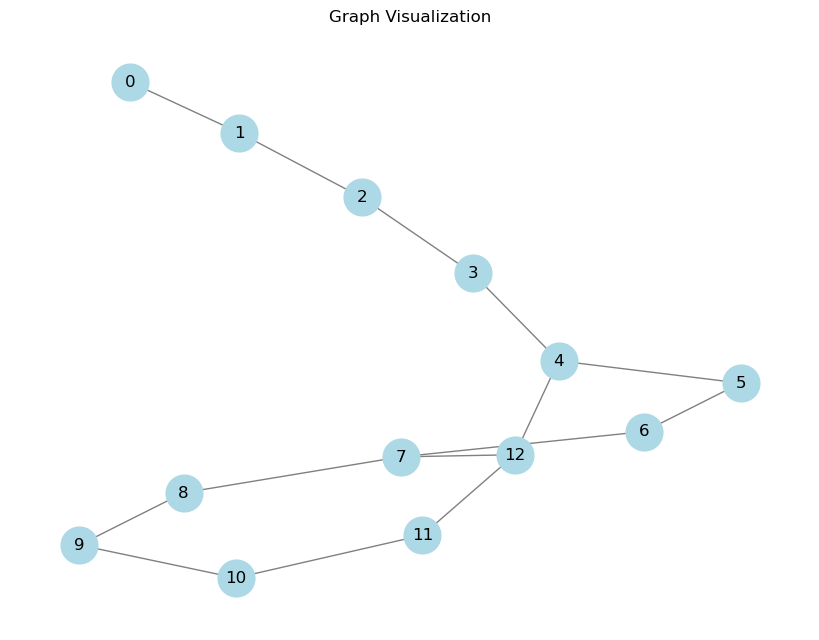

In [20]:
# Convert to NetworkX graph for visualization
G = nx.Graph()

# Add nodes
for i in range(graph.x.shape[0]):
    G.add_node(i)

# Add edges
for i in range(graph.edge_index.shape[1]):
    source = graph.edge_index[0, i].item()
    target = graph.edge_index[1, i].item()
    G.add_edge(source, target)

# Plotting
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', 
        edge_color='gray', node_size=700, font_size=12)
plt.title('Graph Visualization')
plt.show()


## Evaluate Base Model

In [15]:
from BaseModel import NMRNetwork_Base
from torch.utils.data import DataLoader, random_split
from load_fpt_nmr import fpt_nmr_data
input_size = 2048      # Size of the input layer (number of bits in the fingerprint)
output_size = 1001     # Desired size of the output representation 'd'

batch_size = 1
initial_hidden_size = 1024
n_layers = 2

dataset = fpt_nmr_data(csv_file, fpt_path, nmr_path)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

# Create an instance of the network
model = NMRNetwork_Base(input_size, output_size, initial_hidden_size, n_layers)
ckpt_path = 'basemodel_noise_nlayer%d_hdim%d.pt' % (n_layers, initial_hidden_size)
model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu')))

<All keys matched successfully>

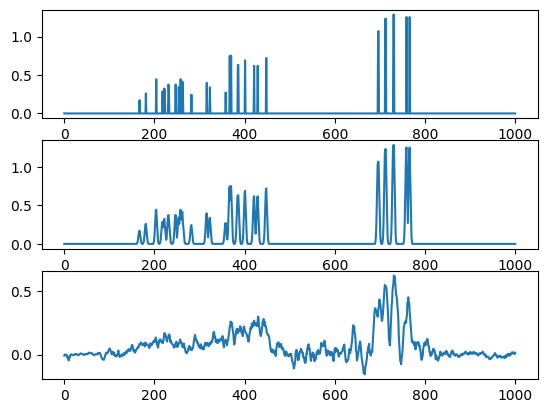

In [18]:
model.eval()
for batch in train_dataloader:
    fpt, nmr, nmr_noise = batch
    loss, out = model(fpt, nmr_noise)
    break

# visualize
nmr = nmr.detach().numpy()
nmr_noise = nmr_noise.detach().numpy()
out = out.detach().numpy()
plt.subplot(311)
plt.plot(np.arange(1001), nmr[0])
plt.subplot(312)
plt.plot(np.arange(1001), nmr_noise[0])
plt.subplot(313)
plt.plot(np.arange(1001), out[0])

In [19]:
loss

tensor(0.0239, grad_fn=<MseLossBackward0>)

### Evaluate GNN Model vs BASE model

In [2]:
import torch
from load_fpt_graph_nmr import fpt_graph_nmr_data
from Comenet_NMR import ComENet
from BaseModel import NMRNetwork_Base
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

csv_file = 'nmr_smile_solvent_3dgnn.csv'
fpt_path = '/scratch0/yunruili/2dnmr_30k/fingerprint/'
graph_path = './graph_3d/'
nmr_path = '/scratch0/yunruili/2dnmr_30k/nmr_1dcsv_30k/'

dataset = fpt_graph_nmr_data(csv_file, fpt_path, graph_path, nmr_path)
dataloader = DataLoader(dataset, shuffle=False, batch_size=10)


/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/yunruili/anaconda_env/diffusion/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [19]:
# load gnn model
agg_method = 'sum'
hidden_channels = 512
out_hidden = [512, 256]
num_layers = 3
num_output_layers = 3

gnn_model = ComENet(in_embed_size=3, out_channels=1001, \
                agg_method=agg_method, hidden_channels=hidden_channels, out_hidden=out_hidden, \
                        num_layers=num_layers, num_output_layers=num_output_layers)
ckpt_path = 'final_gnn3d_%s_hiddendim_%d_nlayers_%d_noutlayers_%d_outhidden_%s.pt' % \
        (agg_method, hidden_channels, num_layers, num_output_layers, ''.join(str(i) for i in out_hidden))
# ckpt_path = 'gnn3d_sum_hiddendim_256_nlayers_2_noutlayers_3_outhidden_512512.pt'
gnn_model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))

# load base model
input_size = 2048      # Size of the input layer (number of bits in the fingerprint)
output_size = 1001     # Desired size of the output representation 'd'
initial_hidden_size = 1024
n_layers = 2
base_model = NMRNetwork_Base(input_size, output_size, initial_hidden_size, n_layers)
ckpt_path = 'base_ckpt/basemodel_noise_nlayer%d_hdim%d.pt' % (n_layers, initial_hidden_size)
base_model.load_state_dict(torch.load(ckpt_path, map_location=torch.device('cpu')))


<All keys matched successfully>

In [20]:
# use both model to do prediction
gnn_model.eval()
base_model.eval()
for batch in dataloader:
    fpt, graph, nmr, nmr_noise, filename = batch
    loss_gnn, out_gnn = gnn_model(graph, nmr_noise)
    loss_base, out_base = base_model(fpt, nmr_noise)
    break
print(loss_gnn, loss_base)

tensor(0.0405, grad_fn=<MseLossBackward0>) tensor(0.0242, grad_fn=<MseLossBackward0>)


In [21]:
# visualize and compare 
nmr = nmr.detach().numpy()
nmr_noise = nmr_noise.detach().numpy()
out_gnn = out_gnn.detach().numpy()
out_base = out_base.detach().numpy()

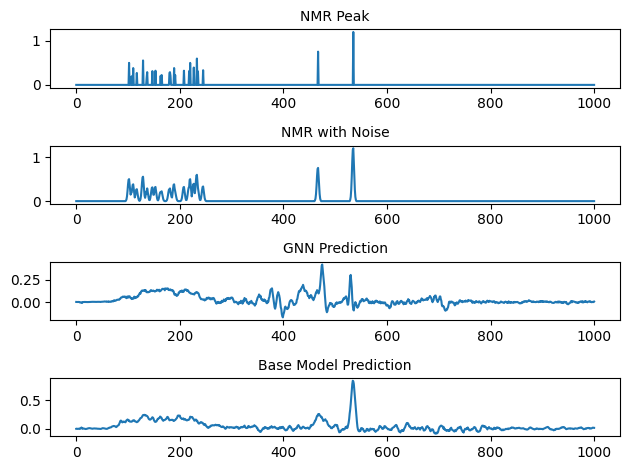

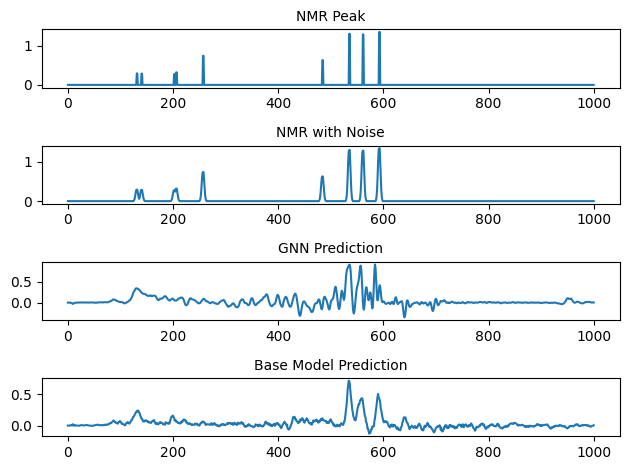

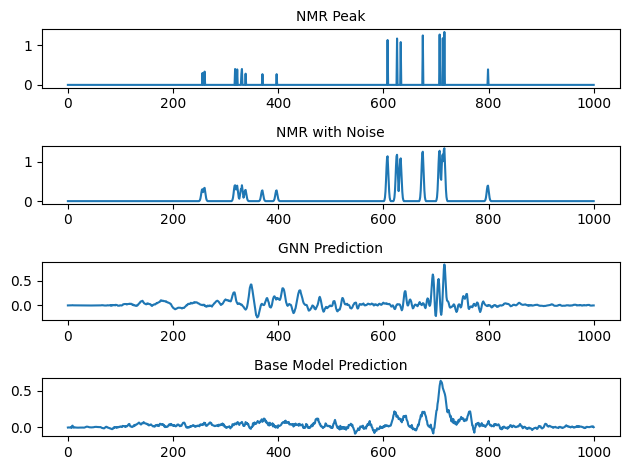

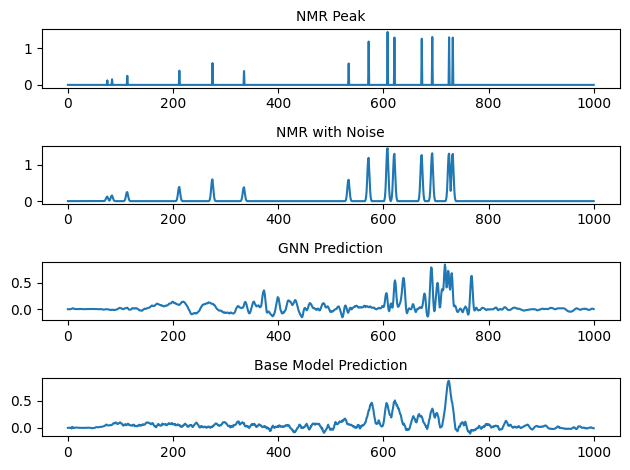

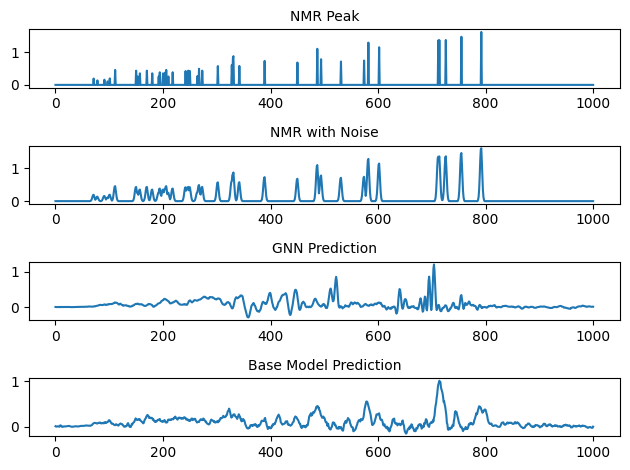

In [22]:
for i in range(0,10,2):
    plt.subplot(411)
    plt.plot(np.arange(1001), nmr[i])
    plt.title('NMR Peak', fontsize=10)
    plt.subplot(412)
    plt.plot(np.arange(1001), nmr_noise[i])
    plt.title('NMR with Noise', fontsize=10)
    plt.subplot(413)
    plt.plot(np.arange(1001), out_gnn[i])
    plt.title('GNN Prediction', fontsize=10)
    plt.subplot(414)
    plt.plot(np.arange(1001), out_base[i])
    plt.title('Base Model Prediction', fontsize=10)
    plt.tight_layout()
    plt.show()

In [1]:
# check nan in model parameters

# from spherenet_NMR import SphereNet
# model = SphereNet(energy_and_force=False, cutoff=3.0, num_layers=2,
#         hidden_channels=128, out_channels=128, int_emb_size=64,
#         basis_emb_size_dist=8, basis_emb_size_angle=8, basis_emb_size_torsion=8, out_emb_channels=256,
#         num_spherical=7, num_radial=6, envelope_exponent=5,
#         num_before_skip=1, num_after_skip=2, num_output_layers=3,
#         output_init='GlorotOrthogonal', use_node_features=True, use_extra_node_feature=False, extra_node_feature_dim=1)
# # Load the checkpoint
# checkpoint = torch.load('final_spherenet_hiddendim_128_cutoff_3_projection_2_batch_64_lr_1.pt', map_location='cpu')

# # Load the state dict into the model
# model.load_state_dict(checkpoint)

# # Function to check if there are NaNs in the model parameters
# def check_nan_parameters(model):
#     for name, param in model.named_parameters():
#         if torch.isnan(param).any():
#             print(f"NaN found in {name}")
#         else:
#             print(name)


# # Check for NaNs
# check_nan_parameters(model)

